In [2]:
import numpy as np
from numpy import linalg

import matplotlib.pyplot as plt
from matplotlib import cm

np.set_printoptions(suppress = True, precision = 3)

Uncomment the following line for interactive graphs:

In [3]:
#%matplotlib widget

Simple probabilistic models such as a gaussian distribution can be used to model certain types of data. Let's implement the density function of a multivariate gaussian distribution. The density function of a $n$-dimensional gaussian distribution of mean $\mu$ (an $n$-dimensional vector) and covariance matrix (an $n\times n$ matrix) is as follows:
$$\mathcal N(x;\mu, \Sigma)=(2\cdot \pi)^{-\frac n2}\cdot \det(\Sigma)^{-\frac 12}\cdot\exp(-\frac12(x-\mu)^T\Sigma^{-1}(x-\mu))$$

Let's first make a generic class to represent a probability distribution. We will implement the `__call__` method for all of its subclasses. We also implement plot methods for `1d` and `2d` distributions, and finally a `plot` method that dispatches the correct plot method depending on dimensions:

In [4]:
class Density():
  def plot_1d(self, xmin = -3, xmax = 3, point_count = 1000, ax = None, scale = 1, *args, **kwargs):
    """
    Plots `density_function` on the interval [xmin, xmax] by taking `point_count` values
    
    ax is used to plot multiple graphs on the same canvas
    the density_function is optionally multipled by the parameter `scale`
    
    extra arguments are passed to the plot function
    """
    x = np.expand_dims(np.linspace(xmin, xmax, point_count), 1)

    if ax is None:
      fig = plt.figure()
      ax = fig.add_subplot(1, 1, 1)
      ax.cla()
    
    ax.plot(x, self(x) * scale, *args, **kwargs)
    ax.set_xlabel("x")
    ax.set_ylabel("p(x)")

    return ax

  def plot_2d(density_function, xmin = -3, xmax = 3, ymin = -3, ymax = 3, point_count = 100, ax = None, scale = 1, *args, **kwargs):
    x = np.linspace(xmin, xmax, point_count)
    y = np.linspace(ymin, ymax, point_count)
    x, y = np.meshgrid(x, y)
    x, y = x.flatten(), y.flatten()

    pos = np.empty((x.shape[0],) + (2, ))
    pos[:, 0] = x.flatten()
    pos[:, 1] = y.flatten()

    z = density_function(pos).reshape((point_count, point_count))
    xr = x.reshape((point_count, point_count))
    yr = y.reshape((point_count, point_count))
    zr = z.reshape((point_count, point_count))

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection = "3d")
    ax.cla()
    ax.plot_surface(xr, yr, zr, cmap=cm.coolwarm)

    return ax

  def plot(self, *args, **kwargs):
    if self.dim == 1:
      return self.plot_1d(*args, **kwargs)
    
    if self.dim == 2:
      return self.plot_2d(*args, **kwargs)
      
    raise NotImplemented

  def likelihood(self, data):
    return np.prod(self(data))

  def log_likelihood(self, data):
    return np.log(self.likelihood(data))

  def sample(self, size):
    return np.random.multivariate_normal(mean = self.mean, cov = self.variance, size = size)

Now we implement a GaussianDensity: it has a mean and a variance, which we take in as arguments in `__init__`. The `__call__` method computes the value of the probability density function: 

In [5]:
class GaussianDensity(Density):
  def __init__(self, mean, variance):
    if type(mean) in [int, float]:
      mean = np.array([mean])
    if type(variance) in [int, float]:
      variance = np.array([[variance]])

    assert mean.shape[0] == variance.shape[0] == variance.shape[1], "mean must be an n-dimensional vector and variance must be an n x n square matrix"

    self.dim = mean.shape[0]

    self.mean = mean
    self.variance = variance

  def __call__(self, x):
    if type(x) in [int, float]:
      x = np.array([[x]])
    value = (2*np.pi)**(-self.dim/2)*linalg.det(self.variance)**(-1/2)*np.exp(-1/2*np.einsum("...b h, b h -> ...b", np.einsum("...h b, h w -> ...b w", (x - self.mean).T, linalg.inv(self.variance)), (x - self.mean)))
    if value.shape[0] == 1:
      value = value.squeeze(0)
    return value

We can now construct the density function of the standard normal and use it to find its value at a given point:

In [6]:
density_1d = GaussianDensity(np.array([0]), np.array([[1]]))

In [7]:
density_1d(0.2)

array(0.391)

And we can do the same for a bivariate (or multivariate) gaussian:

In [8]:
density_2d = GaussianDensity(np.array([0, 0]), np.array(np.eye(2)))

In [9]:
density_2d(np.array([[0.2, 0.4], [0.5, 0.7]]))

array([0.144, 0.11 ])

We can also plot the $2$ gaussians:

<Axes: xlabel='x', ylabel='p(x)'>

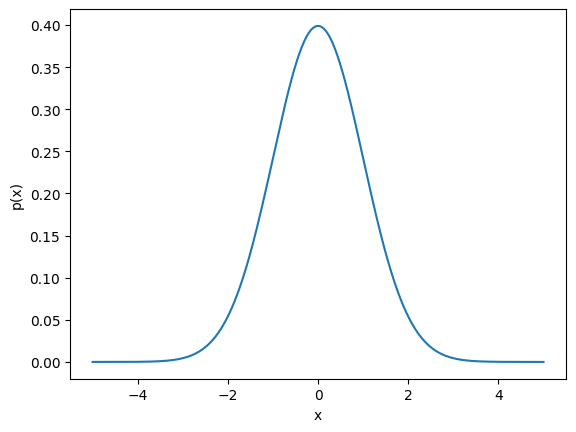

In [10]:
density_1d.plot(xmin = -5, xmax = 5, point_count = 1000)

<Axes3D: >

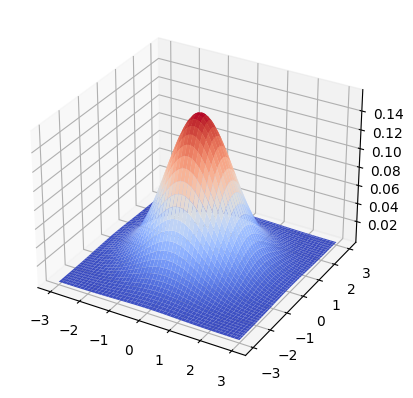

In [11]:
density_2d.plot()

A mixture of gaussians is a weighted sum of gaussian distributions. Because a mixture must still be a distribution, the weights must be positive and sum up to $1$. Let's extend the Density class by implementing a mixture class:

In [12]:
class Mixture(Density):
  def __init__(self, densities, weights):
    if type(weights) == list:
      weights = np.array(weights)
    assert len(densities) == len(weights), "must provide one weight for each density"
    assert np.sum(weights) == 1, "weights must sum up to 1"
    assert not np.any(weights < 0), "weights must be >= 0"
    
    assert np.all(np.array([comp.dim for comp in densities]) == densities[0].dim), "all mixture components must have the same dimensionality"

    self.dim = densities[0].dim

    self.densities = densities
    self.weights = weights

  def plot_mixture_and_components(self, xmin = -10, xmax = 10):
    densities, weights = self.densities, self.weights
    ax = self.plot(xmin = xmin, xmax = xmax, label = "GMM", c = "black", zorder = 10)
    for id, (density, weight) in enumerate(zip(densities, weights)):
      density.plot(xmin = xmin, xmax = xmax, scale = weight, linestyle = "dashed", ax = ax, label = f'Component {id}')

    ax.legend()

  def __call__(self, x):
    return np.sum([weight * density(x) for density, weight in zip(self.densities, self.weights)], axis = 0)

  def __len__(self):
    return len(self.densities)

In [13]:
density1 = GaussianDensity(-2, 1/2)
density2 = GaussianDensity(1, 2)
density3 = GaussianDensity(4, 1)

In [14]:
mixt = Mixture([density1, density2, density3], [0.5, 0.2, 0.3])

<Axes: xlabel='x', ylabel='p(x)'>

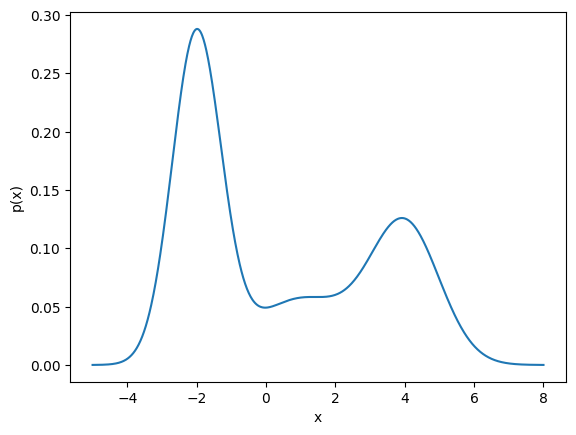

In [15]:
mixt.plot(xmin = -5, xmax = 8)

We can plot the mixture and its components to see how they influence it:

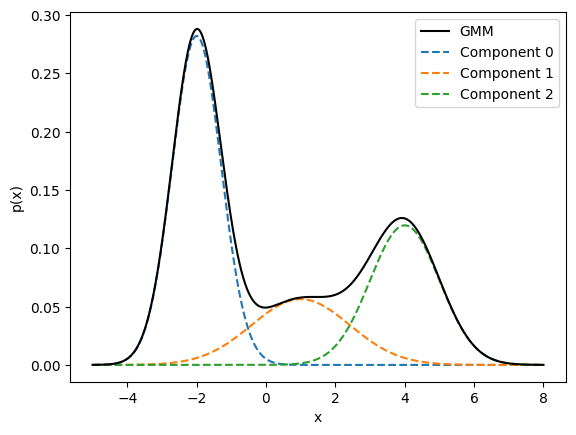

In [16]:
mixt.plot_mixture_and_components(xmin = -5, xmax = 8)

<Axes3D: >

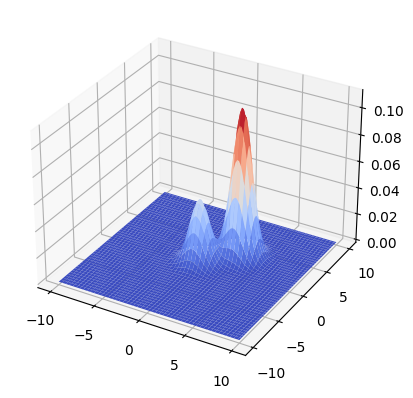

In [17]:
Mixture([GaussianDensity(np.array([0, 0]), np.eye(2)), GaussianDensity(np.array([3, 3]), np.eye(2))], [0.3, 0.7]).plot(xmin = -10, xmax = 10, ymin = -10, ymax = 10)

We will use the toy dataset $\mathcal X=\left\{-3, -2.5, -1, 0, 2, 4, 5\right\}$. We want to find a good representation of this dataset via a mixture of gaussians, which means choosing optimal values for the parameters of this model: the means $\mu$, the covariance matrixes $\Sigma$ and the weights of the gaussians in the mixture. 

We will start with a mixture model of $3$ components:
$$p_1(x)=\mathcal N(x|-4, 1)$$
$$p_2(x)=\mathcal N(x|0, 0.2)$$
$$p_3(x)=\mathcal N(x|8, 3)$$

To start with, we'll consider all $3$ components to have equal weight, $\frac13$.

Let's plot the model and the dataset!

In [18]:
gaussian1 = GaussianDensity(-4, 1)
gaussian2 = GaussianDensity(0, 0.2)
gaussian3 = GaussianDensity(8, 3)

In [19]:
weights = np.array([1/3, 1/3, 1/3])

In [20]:
data = np.expand_dims(np.array([-3, -2.5, -1, 0, 2, 4, 5]), 1)

In [21]:
mixt = Mixture([gaussian1, gaussian2, gaussian3], weights)

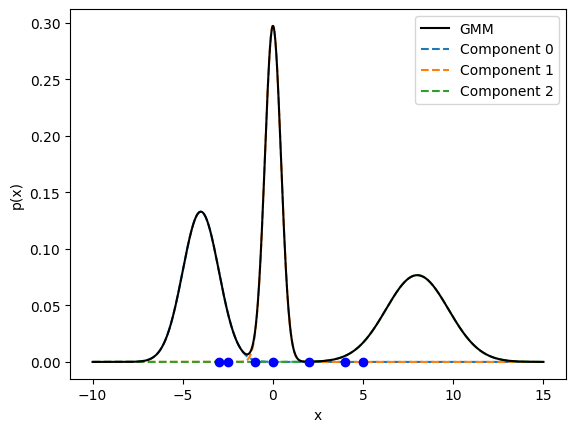

In [22]:
mixt.plot_mixture_and_components(xmin = -10, xmax = 15)
plt.scatter(data, y = np.zeros_like(data), c = "blue", zorder = 100)

To see how good the current model is, we can compute the likelihood of seeing the data (the toy-dataset above) given the current model. We assume the data in our dataset was drawn independently so we can factorize the likelihood of the whole dataset as the product of the individual likelihoods.

Let's write a function that computes the likelihood, and one that computes the log likelihood:

In [23]:
mixt.likelihood(data), mixt.log_likelihood(data)

(4.993167875218712e-13, -28.32553565585463)

We will attempt to find good parameters for model, so let's make a class to help update parameters:

In [24]:
class EM:
  def __init__(self, mixture, data):
    self.mixture = mixture
    self.data = data
    self.cache = dict()
  
  def compute_responsabilities(self):
    component_count = len(self.mixture)
    data_size = len(self.data)
    weights = self.mixture.weights

    top = np.array([self.mixture.densities[i](self.data) for i in range(component_count)]).T
    bottom = np.sum(top * weights, axis = 1)
    
    responsabilities = top * weights / bottom[:, None]
    self.cache["responsabilities"] = responsabilities
    return responsabilities

  def compute_total_responsabilities(self):
    return np.sum(self.cache["responsabilities"], axis = 0)

  def compute_new_means(self):
    responsabilities = self.cache["responsabilities"]
    return np.expand_dims(responsabilities.T.dot(self.data.squeeze(1)) / np.sum(responsabilities, axis = 0), axis = 1)

  def perform_mean_update(self):
    new_means = self.compute_new_means()
    for density, new_mean in zip(self.mixture.densities, new_means):
      density.mean = new_mean

  def compute_new_variances(self):
    responsabilities = self.cache["responsabilities"]
    total_responsabilities = self.compute_total_responsabilities()
    # extract the means from the components
    means = np.array([component.mean for component in self.mixture.densities])
    variances = np.array([np.sum(responsabilities[:, i].reshape(-1, 1, 1) * np.einsum("... b, d ...", (data - means[i]), (data - means[i]).T), axis = 0) / total_responsabilities[i] for i in range(len(self.mixture))])
    return variances

  def perform_variance_update(self):
    new_variances = self.compute_new_variances()
    for density, new_variance in zip(self.mixture.densities, new_variances):
      density.variance = new_variance

  def compute_new_weights(self):
    total_responsabilities = self.compute_total_responsabilities()
    return total_responsabilities / len(self.data)

  def perform_weight_update(self):
    new_weights = self.compute_new_weights()
    self.mixture.weights = new_weights

  def fit(self, eps = 0.01):
    initial = -self.mixture.log_likelihood(self.data)
    likelihoods = [initial]
    while True:
      self.compute_responsabilities()
      self.perform_mean_update()
      self.perform_variance_update()
      self.perform_weight_update()
      updated_likelihood = -self.mixture.log_likelihood(self.data)
      likelihoods.append(updated_likelihood)
      if updated_likelihood > initial or initial - updated_likelihood < eps:
        break

      initial = updated_likelihood

    return likelihoods


Mathematically, the likelihood looks like this (where $\theta$ represents all parameters of the model, $N$ is the number of examples in the dataset and $K$ is the number of basic distributions in the mixture):
$$p(\mathcal X|\theta) = \prod_{n=1}^Np(x_n|\theta)$$
$$p(x_n|\theta)=\sum_{k=1}^K\pi_k\mathcal (x_n|\mu_k, \Sigma_k)$$

We want to maximize likelihood. Optimizing a product is harder than optimizing a sum (for one, the derivative of a product is more involved). Moreover, since likelihoods are rather small numbers, their product can become too small to accurately represent on a computer.

For those reasons we will work with the log-likelihood:
$$\mathcal L=\log p(\mathcal X|\theta)=\sum_{n=1}^N\log p(x_n|\theta)=\sum_{n=1}^N\log(\sum_{k=1}^K\pi_k(x_n|\mu_k, \Sigma_k))$$

Let's see what happens for the case of a single Gaussian ($K=1$ above). The log likelihood becomes:
$$\mathcal L_1=\sum_{n=1}^N\log(\mathcal N(x_n|\mu, \Sigma))$$
$$\mathcal L_1=\sum_{n=1}^N\log((2\cdot \pi)^{-\frac n2}\cdot \det(\Sigma)^{-\frac 12}\cdot\exp(-\frac12(x-\mu)^T\Sigma^{-1}(x-\mu)))$$

Let's see what happens for the case of a single Gaussian ($K=1$ above). The log likelihood becomes:
$$\mathcal L_1=\sum_{n=1}^N\log(\mathcal N(x_n|\mu, \Sigma))$$
$$\mathcal L_1=\sum_{n=1}^N\log((2\cdot \pi)^{-\frac n2}\cdot \det(\Sigma)^{-\frac 12}\cdot\exp(-\frac12(x_n-\mu)^T\Sigma^{-1}(x_n-\mu)))$$
$$\mathcal L_1=\sum_{n=1}^N\log((2\pi)^{-\frac n2})+\log(\det(\Sigma)^{-\frac12})+\log(\exp(-\frac12(x_n-\mu)^T\Sigma^{-1}(x_n-\mu)))$$
$$\mathcal L_1=\sum_{n=1}^N-\frac n2\log(2\pi)-\frac12\log(\det(\Sigma))-\frac12(x_n-\mu)^T\Sigma^{-1}(x_n-\mu)$$

Let's simplify further to a $1\text{D}$ Gaussian:
$$\mathcal L_1=\sum_{n=1}^N-\frac n2\log(2\pi)-\frac12\log(\sigma)-\frac12(x_n-\mu)^2\frac1\sigma$$

The term $-\frac{n}2\log(2\pi)$ is a constant, so it doesn't have any influence when optimizing:
$$\mathcal L_1'=\sum_{n=1}^N-\frac12\log(\sigma)-\frac12(x_n-\mu)^2\frac1\sigma$$

Settings partial derivatives to $0$:
$$\frac{\partial \mathcal L_1'}{\partial \sigma}=0$$
$$\frac{\partial \mathcal L_1'}{\partial \mu}=0$$

Computing the partial derivatives:
$$\frac{\partial \mathcal L_1'}{\partial \sigma}=\sum_{n=1}^N-\frac1{2\sigma}-\frac12(x_n-\mu)^2(-\frac1{\sigma^2})$$
$$\frac{\partial \mathcal L_1'}{\partial \mu}=\sum_{n=1}^N-\frac12\cdot 2(x_n-\mu)\cdot(-1)\frac1\sigma$$

Simplifying:
$$\frac{\partial \mathcal L_1'}{\partial \sigma}=\sum_{n=1}^N-\frac1{2\sigma}+\frac12(x_n-\mu)^2(\frac1{\sigma^2})$$
$$\frac{\partial \mathcal L_1'}{\partial \mu}=\sum_{n=1}^N(x_n-\mu)\cdot\frac1\sigma$$

Setting to $0$:
$$0=\sum_{n=1}^N-\frac1{2\sigma}+\frac12(x_n-\mu)^2(\frac1{\sigma^2})$$
$$0=\sum_{n=1}^N(x_n-\mu)\cdot\frac1\sigma$$

Assuming $\sigma=0$, we multiply by $2\sigma^2$ in the first sum and by $\sigma$ in the second:


$$0=\sum_{n=1}^N-\sigma+(x_n-\mu)^2$$
$$0=\sum_{n=1}^N(x_n-\mu)$$

We write out the sums:

$$0=-N\sigma+\sum_{n=1}^Nx_n^2+N\mu^2-2\mu\sum_{n=1}^Nx_n$$
$$0=\sum_{n=1}^Nx_n-N\mu$$

With the notation $m_1=\sum_{n=1}^Nx_n$ and $m_2=\sum_{n=1}^Nx_n^2$:

$$0=-N\sigma+m_2+N\mu^2-2\mu m_1$$
$$0=m_1-N\mu$$

From the second equation, we get $\mu=\frac{m_1}{N}$. From the first equation, $\sigma=\frac{m_2+N\mu^2-2\mu m_1}{N}=\frac{m_2+N\frac{m_1^2}{N^2}-2\frac{m_1}{N}m_1}{N}$.

This simple case has a closed form. The $K$-gaussians case is more complicated: the $\log$ becomes the $\log$ of a sum. A closed form solution is at the very least a lot more complicated. We can however try to solve the problem numerically.

For the $K$-gaussians case, equating the derivatives to $0$ results in:
$$\frac{\partial\mathcal L}{\partial \mu_k}=0^T$$
$$\frac{\partial\mathcal L}{\partial \Sigma_k}=\mathcal O$$
$$\frac{\partial\mathcal L}{\partial \pi_k}=0$$

$$\sum_{n=1}^N\frac{\partial\log(x_n|\theta)}{\partial\mu_k}=0^T$$
$$\sum_{n=1}^N\frac{\partial\log(x_n|\theta)}{\partial\Sigma_k}=\mathcal O$$
$$\sum_{n=1}^N\frac{\partial\log(x_n|\theta)}{\partial\pi_k}=0$$

We make use of a new quantity called "responsability":
$$r_{nk}=\frac{\pi_k\mathcal N(x_n|\mu_k, \Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(x_n|\mu_j, \Sigma_j)}$$

The numerator represents the likelihood that the $k$-th component produced sample $x_n$, while the denominator denotes the sum of the likelihoods for all of the components to generate sample $x_n$.

This defines a probability distribution for which component generated sample $x_n$:
$$r_n=[r_{n1}, r_{n2}, ..., r_{nk}]$$

Let's compute the responsabilities for the toy-dataset and the mixture model described above:

In [25]:
em = EM(mixt, data)

In [26]:
responsabilities = em.compute_responsabilities()
responsabilities

array([[1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.057, 0.943, 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 0.066, 0.934],
       [0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   ]])

Summing up the values on each column, we get the responsability of each of the components for the whole data.

In [27]:
total_responsabilities = em.compute_total_responsabilities()
total_responsabilities

array([2.057, 2.009, 2.934])

## Updating the means

The means are updated as follows:
$$\mu_k'=\frac{\sum_{n=1}^Nr_{nk}x_n}{\sum_{n=1}^Nr_{nk}}$$

The new mean for the $k$-th component is the weighted mean of the data, weighted by the responsability of the $k$-th component to it. A data point for which the component has a high responsability has a larger influence to the new mean.

Let's write a function to compute the updated means.

In [28]:
em.compute_new_means()

array([[-2.701],
       [-0.403],
       [ 3.704]])

Let's argue for this update mathematically. We will compute the partial derivative of the log-likelihood w.r.t. the means. To do that, we compute the derivative w.r.t. to an individual mean $\mu_k$:
$$\frac{\partial\log(p(x_n|\theta))}{\partial\mu_k}=\frac{\partial p(x_n|\theta)}{\partial\mu_k}\cdot\frac1{p(x_n|\theta)}$$

Above we used the chain rule. The resulting partial derivative becomes:
$$\frac{\partial}{\partial\mu_k}\sum_{j=1}^K\pi_j\mathcal N(x_n|\mu_j, \Sigma_j)$$

Only the $k$-th term of the sum depends on $\mu_k$, so the derivative becomes:
$$\frac{\partial}{\partial\mu_k}\pi_k\mathcal N(x_n|\mu_k, \Sigma_k)$$
$$\frac{\partial}{\partial\mu_k}\pi_k\mathcal (2\cdot \pi)^{-\frac n2}\cdot \det(\Sigma_k)^{-\frac 12}\cdot\exp(-\frac12(x_n-\mu_k)^T\Sigma^{-1}(x_n-\mu_k))$$

Only the exponential term contains the mean vector, and the derivative of $x^TAx$ is known to be equal to $2Ax$ if $A$ is symmetrical (which we assume $\Sigma$ is), leading to:
$$2\Sigma^{-1}\cdot(-\frac12)\cdot(-1)\cdot(x_n-\mu_k)\pi_k\mathcal (2\cdot \pi)^{-\frac n2}\cdot \det(\Sigma_k)^{-\frac 12}\cdot\exp(-\frac12(x_n-\mu_k)^T\Sigma^{-1}(x_n-\mu_k))$$

$$\pi_k\Sigma_k^{-1}\cdot(x_n-\mu_k)\cdot\mathcal N(x_n|\mu_k, \Sigma_k)$$

Substituting back into the derivative of the whole log-likelihood, we get:
$$\frac{\partial \mathcal L}{\partial \mu_k}=\sum_{n=1}^N\frac{\partial\log(p(x_n|\theta))}{\partial\mu_k}$$
$$\frac{\partial \mathcal L}{\partial \mu_k}=\sum_{n=1}^N\pi_k\Sigma_k^{-1}\cdot(x_n-\mu_k)\cdot\mathcal N(x_n|\mu_k, \Sigma_k)\cdot\frac1{p(x_n|\theta)}$$

Notice that the last $2$ terms, together with $\pi_k$, are equal to the responsability of the $k$-component for the $n$-th data point:
$$\frac{\partial \mathcal L}{\partial \mu_k}=\sum_{n=1}^N\Sigma_k^{-1}\cdot(x_n-\mu_k)\cdot r_{nk}$$

To find the update rule for the means, we equate the derivative with $0$:

$$\frac{\partial\mathcal L}{\partial\mu_k}=0^T$$
$$\sum_{n=1}^N\Sigma_k^{-1}\cdot(x_n-\mu_k)\cdot r_{nk} = 0^T$$
$$\sum_{n=1}^N(x_n-\mu_k)\cdot r_{nk} = 0^T$$
$$\sum_{n=1}^N x_n\cdot r_{nk}-\sum_{n=1}^N \mu_k\cdot r_{nk} = 0^T$$
$$\sum_{n=1}^N x_n\cdot r_{nk}=\sum_{n=1}^N \mu_k\cdot r_{nk}$$

We finally arrive at the update rule:
$$\mu_k=\frac{\sum_{n=1}^Nx_n\cdot r_{nk}}{\sum_{n=1}^N{r_{nk}}}$$

Let's write a function that updates our GaussianDensity objects by performing a mean update!

In [29]:
em.perform_mean_update()

We plot the distribution and the points, and compute the log-likelihood for the new parameters:

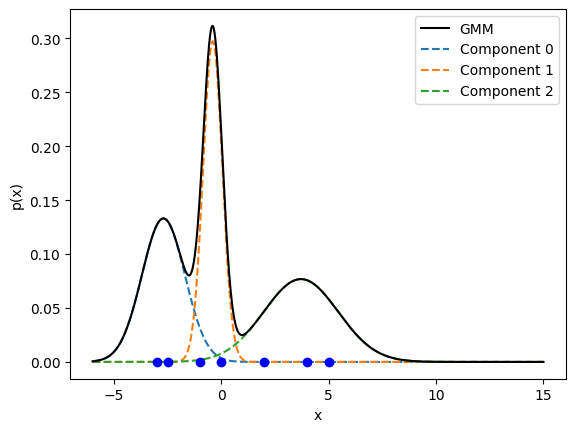

In [30]:
mixt.plot_mixture_and_components(xmin = -6, xmax = 15)
plt.scatter(data, y = np.zeros_like(data), c = "blue", zorder = 100)

In [31]:
mixt.log_likelihood(data)

-16.004150250154286

## Updating the covariances

The update step for the covariance matrixes looks as follows:
$$\Sigma_{k}'=\frac{1}{N_k}\sum_{n=1}^Nr_{nk}(x_n-\mu_k)(x_n-\mu_k)^T$$

This is similar to the definition of the covariance matrix, but each data point is weighted by how much component $k$ is responsible for it.

Let's write a function to compute the updated covariance matrixes:

In [32]:
em.compute_new_variances()

array([[[0.144]],

       [[0.438]],

       [[1.527]]])

Mathematically, we need to find the derivative of the log-likelihood w.r.t. $\Sigma_k$:
$$\frac{\partial \mathcal L}{\partial \Sigma_k}=\sum_{n=1}^N\frac{\partial \log(p(x_n|\theta))}{\partial\Sigma_k}=\sum_{n=1}^N\frac1{p(x_n|\theta)}\cdot\frac{\partial p(x_n|\theta)}{\partial \Sigma_k}$$

To compute the derivative, we remember the probability is a sum of gaussians, where only the $k$-th Gaussian depends on $\Sigma_k$:
$$\frac{\partial p(x_n|\theta)}{\Sigma_k}=\pi_k\frac{\partial\mathcal N(x_n|\mu_k, \Sigma_k)}{\partial\Sigma_k}$$

$$\frac{\partial p(x_n|\theta)}{\Sigma_k}=\pi_k\frac{\partial}{\partial\Sigma_k}(2\cdot \pi)^{-\frac n2}\cdot \det(\Sigma_k)^{-\frac 12}\cdot\exp(-\frac12(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k))$$

We have the derivative of a product, so:

$$\frac{\partial p(x_n|\theta)}{\Sigma_k}=\pi_k\cdot (2\cdot \pi)^{-\frac n2}(\exp(-\frac12(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k))\cdot\frac{\partial}{\partial\Sigma_k}\det(\Sigma_k)^{-\frac 12} + \det(\Sigma_k)^{-\frac 12}\cdot\frac{\partial}{\partial\Sigma_k}\exp(-\frac12(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)))$$

$$\frac{\partial}{\partial \Sigma_k}\det (\Sigma_k)^{-\frac12}=-\frac12\det(\Sigma_k)^{-\frac32}\frac{\partial}{\partial\Sigma_k}(\det(\Sigma_k))$$

For an element $\sigma_{ij}$, to compute the derivative w.r.t to it, we can perform expansion along its row or column. In the resulting sum, only the term coresponding to $\sigma_{ij}$ depends on $\sigma_{ij}$, and the actual derivative of this sum will be the corresponding minor. Together with the $(-1)^{i+j}$ term in the expansion, the resulting derivative is exactly the $(i, j)$ cofactor of $\Sigma_k$. The derivative w.r.t the whole matrix will therefore be the cofactor matrix of $\Sigma_k$:

$$\frac{\partial}{\partial\Sigma_k}\det(\Sigma_k)=\begin{pmatrix}C(1, 1) & C(1, 2) & C(1, 3) & ... & C(1, n)\\.\\.\\.\\C(n, 1) & C(n, 2) & C(n, 3) & ... & C(n, n)\end{pmatrix}$$

Since $A^{-1}=\frac{1}{\det(A)}A_{\text{adj}}=\frac1{\det(A)}C^T$, and that $\Sigma$ is a symmetric matrix it follows that $C=\det(\Sigma)\Sigma^{-1}$:

$$\frac{\partial \det(\Sigma_k)}{\partial\Sigma_k}=\det(\Sigma_k)\Sigma_k^{-1}$$

Then the whole derivative of the determinant term is:

$$\frac{\partial}{\partial \Sigma_k}\det (\Sigma_k)^{-\frac12}=-\frac12\det(\Sigma_k)^{-\frac32}\det(\Sigma_k)\Sigma_k^{-1}$$

$$\frac{\partial}{\partial \Sigma_k}\det (\Sigma_k)^{-\frac12}=-\frac12\det(\Sigma_k)^{-\frac12}\Sigma_k^{-1}$$

Now we need to compute:

$$\frac{\partial}{\partial\Sigma_k}\exp(-\frac12(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k))$$

$$\exp(-\frac12(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k))\cdot\frac{\partial}{\partial\Sigma_k}(-\frac12(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k))$$

Apparently $\frac{\partial a^TX^{-1}b}{\partial X}=-(X^{-1})^Tab^T(X^{-1})^T$, and $\Sigma_{k}$ is symmetric so the derivative becomes:

$$\exp(-\frac12(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k))\cdot\frac12X^{-1}(x-\mu_k)(x-\mu_k)^TX^{-1}$$

Substituting into the derivative:

$$\frac{\partial p(x_n|\theta)}{\Sigma_k}=\pi_k\cdot (2\cdot \pi)^{-\frac n2}(\exp(-\frac12(x_n-\mu_k)^T\Sigma_k^{-1}(x_n-\mu_k))\cdot(-\frac12\det(\Sigma_k)^{-\frac12}\Sigma_k^{-1}) + \det(\Sigma_k)^{-\frac 12}\cdot\exp(-\frac12(x_n-\mu_k)^T\Sigma_k^{-1}(x_n-\mu_k))\cdot\frac12\Sigma_k^{-1}(x_n-\mu_k)(x_n-\mu_k)^T\Sigma_k^{-1})$$

We factor out the terms of the normal distribution:
$$\frac{\partial p(x_n|\theta)}{\Sigma_k}=\pi_k\mathcal N(x_n|\mu_k, \Sigma_k)(-\frac12\Sigma_k^{-1}+\frac12\Sigma_k^{-1}(x_n-\mu_k)(x_n-\mu_k)^T\Sigma_k^{-1})$$

Plugging in to the likelihood:

$$\frac{\partial\mathcal L}{\partial\Sigma_k}=\sum_{n=1}^N\frac{1}{p(x_n|\theta)}\pi_k\mathcal N(x_n|\mu_k, \Sigma_k)(-\frac12\Sigma_k^{-1}+\frac12\Sigma_k^{-1}(x_n-\mu_k)(x_n-\mu_k)^T\Sigma_k^{-1})$$

Getting rid of the $-\frac12$ and using the responsabilities:

$$\sum_{n=1}^Nr_{nk}(\Sigma_k^{-1}-\Sigma_k^{-1}(x_n-\mu_k)(x_n-\mu_k)^T\Sigma_k^{-1})$$

Since this will be equated to the zero matrix, we can get rid of one $\Sigma_k^{-1}$:

$$\sum_{n=1}^Nr_{nk}(I-(x_n-\mu_k)(x_n-\mu_k)^T\Sigma_k^{-1}) = 0$$

$$\sum_{n=1}^Nr_{nk}I=\sum_{n=1}^N(x_n-\mu_k)(x_n-\mu_k)^T\Sigma_k^{-1}$$

$$\Sigma_k\sum_{n=1}^Nr_{nk}=\sum_{n=1}^N(x_n-\mu_k)(x_n-\mu_k)^T$$

$$\Sigma_k=\frac{\sum_{n=1}^N(x_n-\mu_k)(x_n-\mu_k)^T}{\sum_{n=1}^Nr_{nk}}$$

Let's write a function to update the variances of our density objects:

In [33]:
em.perform_variance_update()

In [34]:
mixt.densities[0].variance

array([[0.144]])

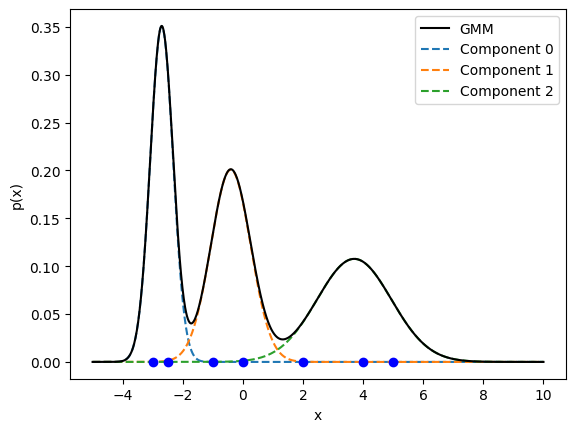

In [35]:
mixt.plot_mixture_and_components(xmin = -5, xmax = 10)
plt.scatter(data, y = np.zeros_like(data), c = "blue", zorder = 100)

In [36]:
mixt.log_likelihood(data)

-14.547617146369875

## Updating the weights

The update step of the weights looks like this:

$$\pi_k'=\frac{N_k}{N}$$

$N_k$ is the sum of the responsabilities of component $k$, and $N$ is the number of data points, which is also equal to the sum of all the responsabilities. So the components that are responsible for more of the data receive a larger weight.

In [37]:
em.compute_new_weights()

array([0.294, 0.287, 0.419])

Mathematically, we introduce the Lagrange multiplier $\lambda$ for the condition $\sum_{k=1}^K\pi_k=1$, and optimize the following quantity:

$$\mathcal J = \mathcal L + \lambda(\sum_{k=1}^K\pi_k - 1)$$

$$\mathcal J = \sum_{n=1}^N\log(\sum_{j=1}^K\pi_j\mathcal N(x_n|\mu_j,\Sigma_j))+\lambda(\sum_{j=1}^K\pi_j-1)$$

The derivative w.r.t. $\pi_k$ is:

$$\frac{\partial J}{\partial\pi_k}=\sum_{n=1}^N\frac{\mathcal N(x_n|\mu_k,\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(x_n|\mu_j,\Sigma_j)}+\lambda$$

$$\frac{\partial J}{\partial\pi_k}=\sum_{n=1}^N\frac1{\pi_k}r_{nk}+\lambda$$

$$\frac{\partial J}{\partial\pi_k}=\frac{N_k}{\pi_k}+\lambda$$

The derivative w.r.t. $\lambda$ is:

$$\frac{\partial\mathcal J}{\partial\lambda}=\sum_{j=1}^K\pi_j-1$$

Equating both to $0$, we get:

$$\pi_k=-\frac{N_k}{\lambda}$$
$$\sum_{j=1}^K\pi_j-1=0$$

The first equation is satisfied for any $k$, so we can use it in the second one:

$$\sum_{j=1}^K-\frac{N_k}{\lambda}-1=0$$

Since the sum of the responsabilities of each mixture component is equal to the size of the dataset, we get:

$$-\frac{N}{\lambda}=1$$

$\lambda = -N$

Finally, we obtain $\pi_k=-\frac{N_k}{-N}=\frac{N_k}{N}$.

In [38]:
em.perform_weight_update()

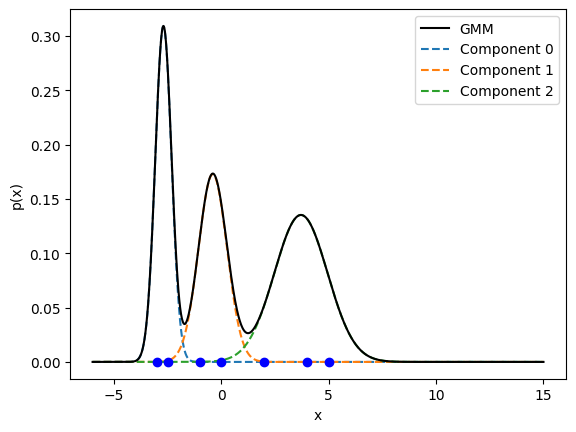

In [39]:
mixt.plot_mixture_and_components(xmin = -6, xmax = 15)
plt.scatter(data, y = np.zeros_like(data), c = "blue", zorder = 100)

In [40]:
mixt.log_likelihood(data)

-14.410485293107607

In [41]:
gaussian1 = GaussianDensity(-4, 1)
gaussian2 = GaussianDensity(0, 0.2)
gaussian3 = GaussianDensity(8, 3)

weights = np.array([1/3, 1/3, 1/3])

mixt = Mixture([gaussian1, gaussian2, gaussian3], weights)

In [42]:
em2 = EM(mixt, data)

In [43]:
nnls = em2.fit(eps = 0.0001)

In [44]:
nnls

[28.32553565585463,
 14.410485293107607,
 13.97705751067481,
 13.973341545540347,
 13.97332368509673]

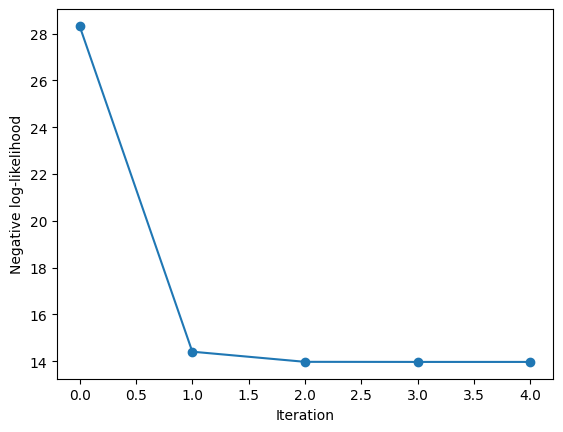

In [45]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.cla()
ax.set_xlabel("Iteration")
ax.set_ylabel("Negative log-likelihood")
ax.plot(nnls, marker="o")

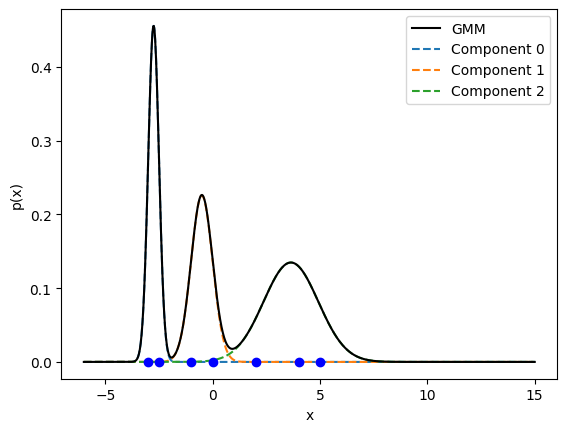

In [46]:
mixt.plot_mixture_and_components(xmin = -6, xmax = 15)
plt.scatter(data, y = np.zeros_like(data), c = "blue", zorder = 100)